# Bayesian Optimization using a Quantum Gaussian Process Surrogate Model 

In this notebook, we will perform a Bayesian Optimization by using sQUlearn's implementations of Quantum Gaussian Processes [squlearn.kernel.QGPR](https://sQUlearn.github.io/modules/generated/squlearn.kernel.ml.QGPR.html) and Fidelity Kernels [squlearn.kernel.FidelityKernel](https://sQUlearn.github.io/modules/generated/squlearn.kernel.matrix.FidelityKernel.html).
<center>
<img src="images/quantum_bo.png" alt="quantum_bo" width="800"/>

*Fig. 1: Conceptual layout of a quantum Bayesian optimization using a QGPR surrogate, taken from [Rapp, F., Roth, M.](https://link.springer.com/article/10.1007/s42484-023-00138-9)*
</center>

Bayesian optimization is a global optimization method that solves problems of the form
$$\boldsymbol{x}^* = \text{arg} \min_{\boldsymbol{x}} g(\boldsymbol{x})\,.$$
The optimization proceeds iteratively, selecting the next sample based on information gathered from previous iterations. This informed approach typically demands only a modest number of samples, rendering it appealing for scenarios where evaluating $g$ is expensive. By treating $g$ as a black-box, Bayesian optimization imposes no constraints on its functional form.

The algorithm starts by randomly selecting a sample and creating a *surrogate model* to represent $g$. Subsequent samples are chosen based on a balance between exploiting known information and exploring new areas, quantified by an *acquisition function*. This process is iterated to improve the accuracy of the surrogate model in approximating the true function. Gaussian process models are often preferred for surrogates due to their posterior variance output. A common choice for an acquisition function is the expected improvement (EI) 
$$\mathrm{EI}(\boldsymbol{x}) = 
		[g(\boldsymbol{x}^+) - \mu(\boldsymbol{x}) - \lambda] \boldsymbol{\Phi}(Z) + \Sigma(\boldsymbol{x}) \varphi(Z)\,$$
Here $\mu(\boldsymbol{x})$ and $\Sigma(\boldsymbol{x})$ are the posterior mean prediction and the prediction uncertainty of the surrogate model at position $\boldsymbol{x}$, and $\varphi(Z)$, and $\boldsymbol{\Phi}(Z)$ are the probability distribution and the cumulative distribution of the standard normal distribution. The location of the best sample, i.e., the current observed minimum of the surrogate model, is indicated by $\boldsymbol{x}^+$. The standardized prediction error $Z$ is given by $Z = [f(\boldsymbol{x}^+) - \mu(\boldsymbol{x}) - \lambda]/\Sigma(\boldsymbol{x})$ if $\Sigma(\boldsymbol{x}) > 0$ and $Z=0$ if $\Sigma(\boldsymbol{x}) = 0$. The parameter $\lambda$ is a hyperparameter that controls the exploitation-exploration trade-off, where a high value of $\lambda$ favours exploration.

We obtain a quantum Bayesian optimization (QBO) algorithm by using a QGP model as a surrogate model.

The follwing example will adapt the structre of the examples made in [scikit-optimize](https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html).

We start by defining the Bayesian optimization base class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, OptimizeResult
from scipy.stats import norm
from skopt.space import Space


class BayesOpt:
    def __init__(
        self,
        f,
        domain,
        surrogate_model,
        random_state,
        nr_initial_points=None,
        X_plot=None,
        Y_plot=None,
        acquisition="EI",
        xi=0.01,
        plot_iters=False,
    ):
        self.surrogate = surrogate_model
        self.acquisition = acquisition
        self.blackbox_function = f
        self.xi = xi
        self.rnd = random_state

        # preparation of the search space
        self.space = Space(domain)

        self._initial_samples = self.space.rvs(
            n_samples=nr_initial_points, random_state=random_state
        )

        self.X = self._initial_samples
        Y_init = [self.blackbox_function(xi) for xi in self.X]
        self.Y = np.array(Y_init).reshape(-1, 1)
        self.X_plot = X_plot
        self.Y_plot = Y_plot

        self.plot_surrogate_acquisition = plot_iters  # Control whether to plot at each step

    def expected_improvement(self, X, X_sample, Y_sample, gpr):
        mu, sigma = gpr.predict(X, return_std=True)
        mu_sample = gpr.predict(X_sample)
        sigma = sigma.reshape(-1, 1)
        mu_sample_opt = np.max(mu_sample)

        with np.errstate(divide="warn"):
            imp = mu - mu_sample_opt - self.xi
            Z = imp / sigma
            ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
            ei[sigma == 0.0] = 0.0

        return ei.ravel()

    def propose_location(self, acquisition, X_sample, Y_sample, gpr, bounds):
        dim = self.space.n_dims
        bounds = np.array(bounds)
        min_val = np.inf
        min_x = None

        def min_obj(X):
            # Minimization objective is the negative acquisition function
            return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)

        # Find the best optimum by starting from n_restart different random points.
        for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(self.restarts, dim)):
            # add a maxiter of 10 to the optimizer
            res = minimize(
                min_obj, x0=x0, bounds=bounds, method="L-BFGS-B", options={"maxiter": 10}
            )
            if res.fun < min_val:
                min_val = res.fun
                min_x = res.x
        print("next sample X position: ", min_x)
        return min_x

    def run_optimization(self, n_iter, n_restarts=1):
        self.n_iter = n_iter
        X_sample = np.array(self.X)
        Y_sample = self.Y

        self.restarts = n_restarts
        self.n_iter = n_iter

        if self.acquisition == "EI":
            acq_func = self.expected_improvement

        for i in range(n_iter):
            # Update Gaussian process with existing samples
            self.surrogate.fit(X_sample, Y_sample)

            X_next = self.propose_location(
                acq_func, X_sample, Y_sample, self.surrogate, self.space.bounds
            )
            X_next = np.array([X_next]).reshape(1, -1)

            Y_next = [self.blackbox_function(xi) for xi in X_next]

            # Add sample to previous samples
            X_sample = np.vstack((X_sample, X_next))
            Y_sample = np.vstack((Y_sample, Y_next))

            # Plot surrogate and acquisition at each step
            if self.plot_surrogate_acquisition:
                self.plot_surrogate(i, X_sample, Y_sample)

        result = OptimizeResult()
        best = np.argmin(Y_sample)
        result.x = X_sample[best]
        result.fun = Y_sample[best]
        result.func_vals = Y_sample
        result.space = self.space
        result.x_iters = X_sample
        return result

    def plot_surrogate(self, step, X_sample, Y_sample):
        if self.X_plot is None:
            raise ValueError("X_plot is None. Surrogate function cannot be plotted.")

        y_pred, sigma = self.surrogate.predict(self.X_plot, return_std=True)

        plt.title(f"Surrogate Function (Step {step + 1})")
        plt.plot(self.X_plot, self.Y_plot, "k--", label="Noise-free objective")
        plt.scatter(X_sample, Y_sample, color="red", marker="x", label="Samples")
        plt.plot(self.X_plot, y_pred, label="Surrogate function", color="blue")
        plt.fill_between(
            self.X_plot[:, 0],
            y_pred[:, 0] - 1.96 * sigma,
            y_pred[:, 0] + 1.96 * sigma,
            alpha=0.2,
            color="blue",
        )
        plt.xlabel("X")
        plt.ylabel("Surrogate Value")
        plt.legend()
        plt.show()

        if step == self.n_iter - 1:
            y_conv = np.minimum.accumulate(Y_sample)
            plt.plot(y_conv, "ro-")
            plt.xlabel("Iteration")
            plt.ylabel("Min f(x)")
            plt.title("Convergence plot")

Note:
<ul>
    <li>In this example, we only used the EI acquisition function. This can be easily exchanged through a customised acquisition function.
    <li>There might be some rescaling of the inputs necessary, depending on the choice of data encoding circuit
    <li>A custom plot_surrogate function is available, but only if there is an analitically know representation of your objective function
<ul>

To get an intuition how Bayesian optimization works, we perform it the mimization of a known objective function with noisy samples.
This will allow us to plot exactly what happens in each iteration step.

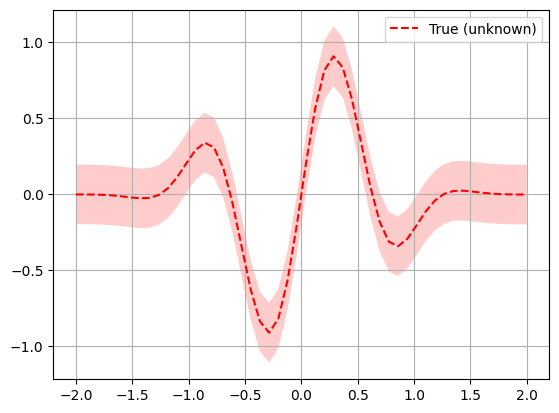

In [2]:
# objective function initialization
noise_level = 0.1


def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level


# Plot f(x) + contours
x = np.linspace(-2, 2, 50).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(
    np.concatenate([x, x[::-1]]),
    np.concatenate(
        (
            [fx_i - 1.96 * noise_level for fx_i in fx],
            [fx_i + 1.96 * noise_level for fx_i in fx[::-1]],
        )
    ),
    alpha=0.2,
    fc="r",
    ec="None",
)
plt.legend()
plt.grid()
plt.show()

In [3]:
# create the qgpr surrogate model

from squlearn.util import Executor
from squlearn.encoding_circuit import HubregtsenEncodingCircuit
from squlearn.kernel.matrix import FidelityKernel
from squlearn.kernel.ml import QGPR

# set up quantum kernel and qgpr
num_qubits = 4
enc_circ = HubregtsenEncodingCircuit(num_qubits, num_features=1, num_layers=3)
q_kernel = FidelityKernel(encoding_circuit=enc_circ, executor=Executor(), parameter_seed=0)
qgpr_model = QGPR(quantum_kernel=q_kernel, sigma=0.01**2)

Note:
<ol>
    <li>The performance and results can be dependent on the choice of encoding strateg, and its hyperparameters (e.g. number qubits / layers / parameters).
    <li>Depending on the number of function samples, the algorithm can run for quite a while. Especially when using a shot based simulator (e.g. QASM)
    <li>We will start with 4 random samples and then perform the Bayesian optimization.
<ol>

next sample X position:  [1.59266487]


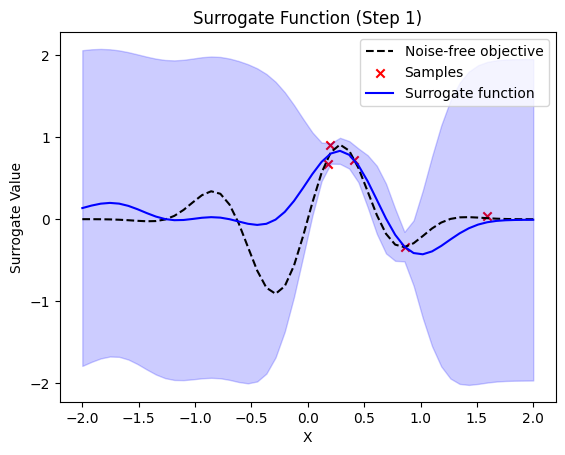

next sample X position:  [-1.65935051]


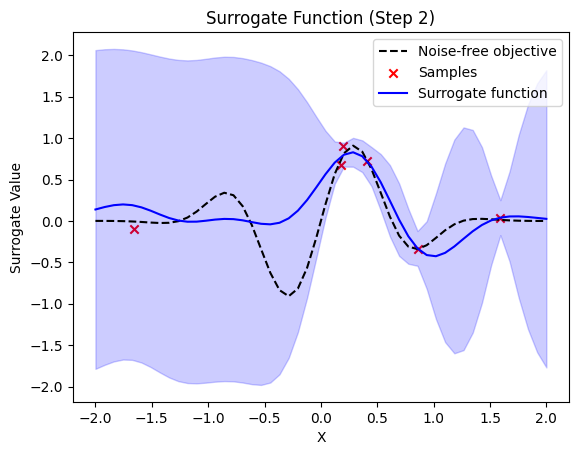

next sample X position:  [1.99999685]


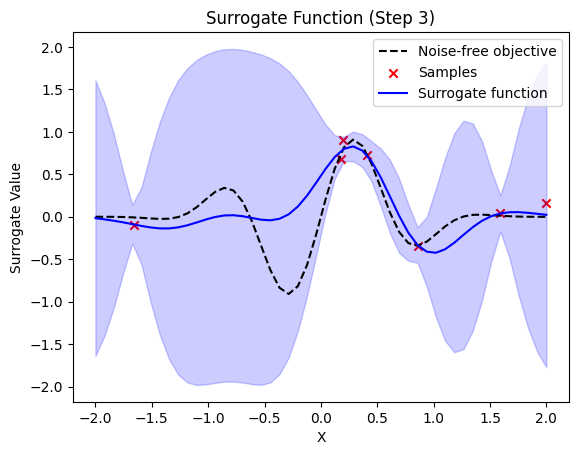

next sample X position:  [0.39188948]


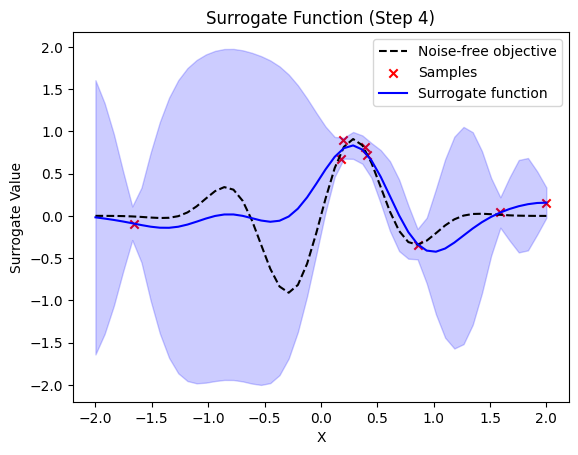

next sample X position:  [1.02765489]


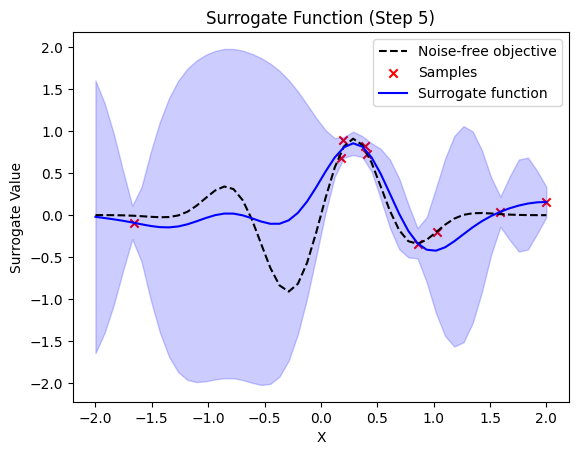

next sample X position:  [-0.13690848]


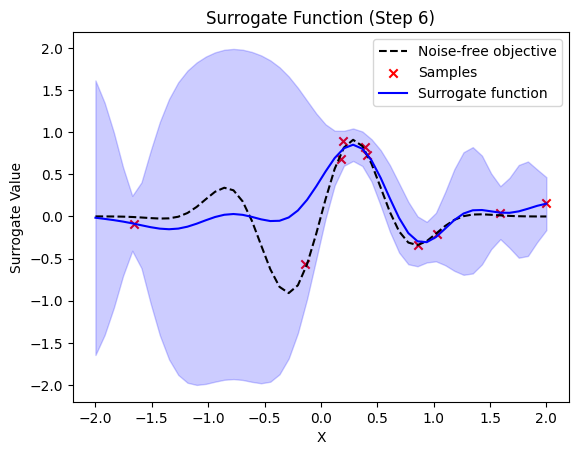

next sample X position:  [0.27936704]


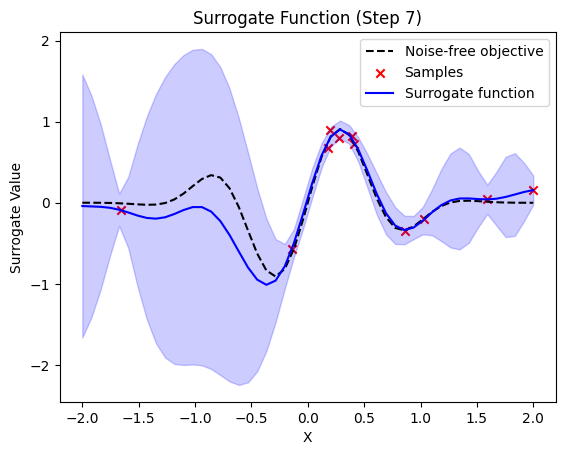

next sample X position:  [1.99631079]


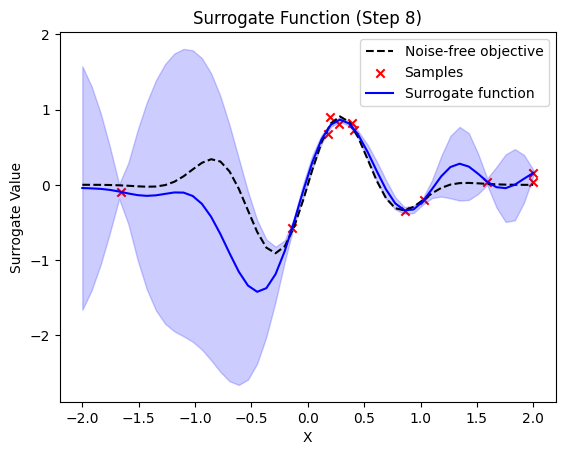

next sample X position:  [-1.0862532]


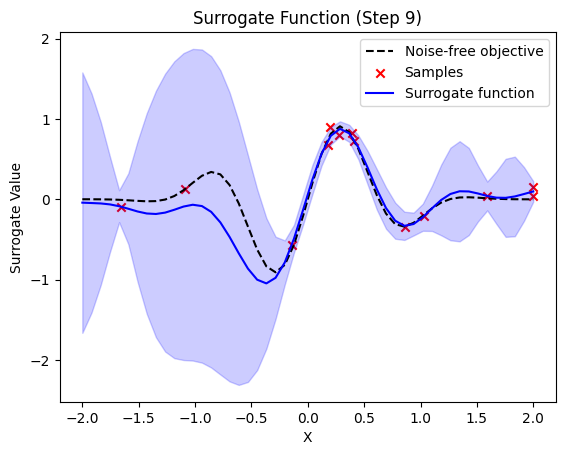

next sample X position:  [0.45667715]


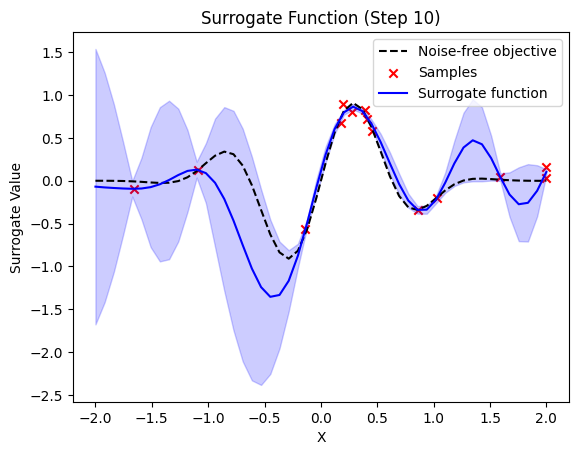

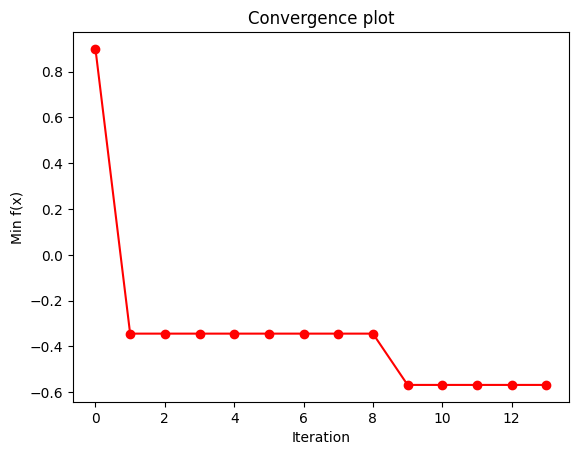

In [4]:
# perform bayesian optimization with qgpr
qBO = BayesOpt(
    f,
    domain=[(-2.0, 2.0)],
    surrogate_model=qgpr_model,
    random_state=0,
    nr_initial_points=4,
    acquisition="EI",
    xi=0.01,
    plot_iters=True,
    X_plot=x,
    Y_plot=fx,
)

result = qBO.run_optimization(n_iter=10)

For the QGPR the choice of Projected Quantum Kernels [squlearn.kernel.ProjectedQuantumKernel](https://sQUlearn.github.io/modules/generated/squlearn.kernel.matrix.ProjectedQuantumKernel.html) is also possible. 
The algorithm can also be applied to more sophisticated problems. E.g., we used it to optimize the price prediction of industrial machinery. The intrested reader can learn more about it from our pre-print [Quantum Gaussian Process Regression for Bayesian Optimization](https://link.springer.com/article/10.1007/s42484-023-00138-9).
